## Description

In this notebook we show information regarding the nanomet dataset and create a model that predicts the reflectivity value of a determined nanostructured surface. 

Specifically, we train Neural networks with the Keras library

#For this part we are also focusing on making functions for the code and apply transfer learning

### 1) Import Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import random

import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pickle
import glob

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold


# define a quick function for mean relative absolute error
def mean_relative_absolute_error(y_true, y_pred):
    x=sum(np.abs((y_true - y_pred)) / y_true ) /len(y_true)
    return x

from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers


from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from sklearn.preprocessing import MinMaxScaler

In [2]:
# for plotting horizontally

In [3]:
from IPython.display import HTML
import io
import base64


class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))

## 2) Data exploration and analysis

In [4]:
#read the data with pandas and convert to a dataframe
df2 = pd.read_csv("data/grating_nanomet_v1.txt", sep = " ",skiprows=1,header = None,delimiter=r"\s+",names = ['h','top','base','wavelength','Reflectance'])

In [5]:
#Add index simulation based on unique input values
def add_simulation_index(df2):
    df_col = df2.groupby(['h','top','base']).size().reset_index().rename(columns={0:'count'})
    df3 = df2.reset_index().rename(columns = {'index': 'Simulation index'}, inplace = False)

    i=1
    for index, row in df_col.iterrows():
        df3.loc[(df3['h'] == row['h']) & (df3['top'] == row['top']) & (df3['base'] == row['base']),'Simulation index'] = i
        i+=1
    return df3

In [6]:
df3 = add_simulation_index(df2)

In [7]:
def plot_spectrums(df3,value_start = 1,value_end = 4000):
    a4_dims = (8, 5)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.lineplot(ax=ax,data=df3[value_start:value_end], x="wavelength", y='Reflectance',hue = "Simulation index")
    plt.ylabel('Reflectivity',fontsize=12)
    plt.xlabel('Wavelength (nm)',fontsize=12)

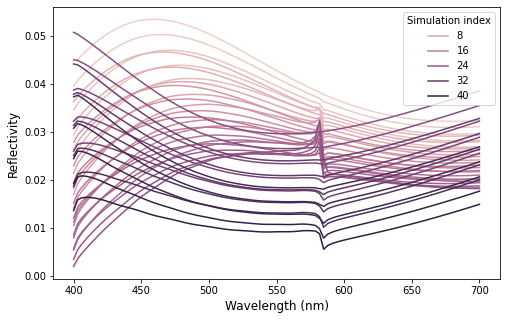

In [8]:
plot_spectrums(df3,value_start = 1,value_end = 4000)

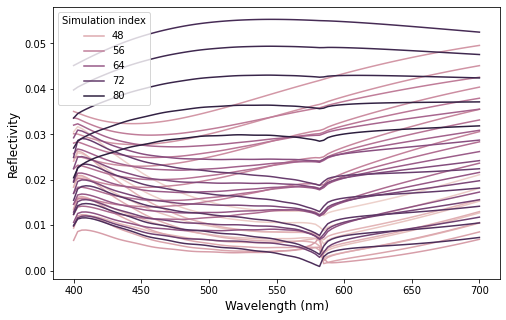

In [9]:
plot_spectrums(df3,value_start = 4000,value_end = 8000)

## 3) Model Training & Testing

In [10]:
#getting our features
features = df3.drop(['Simulation index', 'Reflectance'],axis= 1).columns.tolist()

In [11]:
#scale input
scaler_f = MinMaxScaler()

df3[['h','top','base','wavelength']] = scaler_f.fit_transform(df3[['h','top','base','wavelength']])

In [12]:
#DROP OUT spectra for testing later
df4 = df3[(df3['Simulation index'] != 13) & (df3['Simulation index'] != 14) & (df3['Simulation index'] != 15) & (df3['Simulation index'] != 70) & (df3['Simulation index'] != 71)]
df5 = df3[(df3['Simulation index'] == 13) | (df3['Simulation index'] == 14) | (df3['Simulation index'] == 15) | (df3['Simulation index'] == 70) | (df3['Simulation index'] == 71)]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df4.drop(['Simulation index', 'Reflectance'], axis=1), # predictive variables
    df4['Reflectance'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=8790, # we are setting the seed here
)

X_train.shape, X_test.shape

((7600, 4), (1900, 4))

In [14]:
# get the model
def get_model(n_inputs, n_outputs):
    
	net1Model=keras.models.Sequential()
	net1Model.add(Dense(n_inputs,input_shape=(4,)))
	net1Model.add(Dense(240))
	net1Model.add(Activation('relu'))
	net1Model.add(Dense(30))
	net1Model.add(Activation('relu'))
	net1Model.add(Dense(1024))
	net1Model.add(Activation('relu'))
	net1Model.add(Dense(n_outputs))
	net1Model.compile(optimizer='Adam',loss='mse',metrics= MeanAbsolutePercentageError())
	return net1Model

Here we train the model and show the error of the actual test values compared to the predicted ones from the random heldout test dataset

If you want to see the training progress put verbose = 1

60/60 [==============================] - 0s 510us/step - loss: 2.8059e-07 - mean_absolute_percentage_error: 2.5309


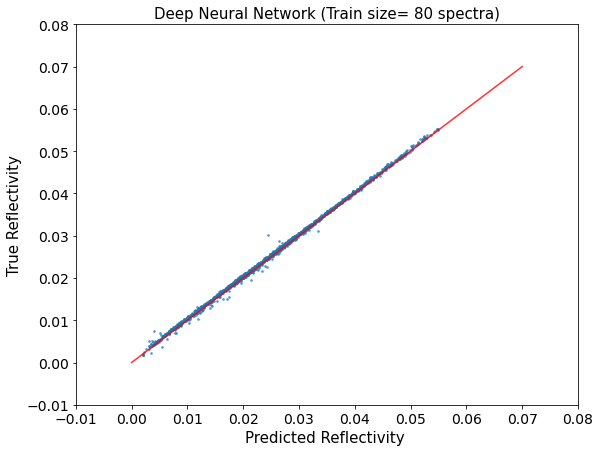

In [15]:
n_inputs, n_outputs = X_train.shape[1],1
model_forward = get_model(n_inputs, n_outputs)

# fit model
model_forward.fit(X_train, y_train, verbose=0, epochs=300)

# evaluate model on test set
#mae = model.evaluate(X_train, y_train, verbose=0)
mae = model_forward.evaluate(X_test, y_test, verbose=1)    
pred= model_forward.predict(X_test)

plt.figure(figsize=(9,7))
plt.scatter(pred,y_test,alpha=0.6,s=3)
plt.plot([0, 0.07],[0, 0.07],'r',alpha=0.8)
plt.ylabel('True Reflectivity',fontsize=15)
plt.xlabel('Predicted Reflectivity ',fontsize=15)
plt.title('Deep Neural Network (Train size= 80 spectra)',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.01, 0.08])
plt.ylim([-0.01,  0.08])
plt.show()


In [16]:
#function for testing predictions in forward problem

def viz_forward_prediction(df3,model_forward, spectra_num):
    df_helout = df3[df3['Simulation index'] == spectra_num]
    pre_heldout= model_forward.predict(df_helout.drop(['Simulation index', 'Reflectance'], axis=1))

    plt.plot(df_helout['wavelength'], pre_heldout, 'r') # plotting t, a separately 
    plt.plot(df_helout['wavelength'], df_helout['Reflectance'], 'b') # plotting t, b separately
    plt.title('Testing spectrum: '+ str(spectra_num) ,fontsize=12)
    plt.ylabel('Reflectivity',fontsize=12)
    plt.xlabel('Normalized wavelength',fontsize=12)
    error_percentage = sklearn.metrics.mean_absolute_percentage_error(df_helout['Reflectance'], pre_heldout)
    
    plt.show() 
    #show error
    print( f" MA Percentage error is: {100*error_percentage}.")

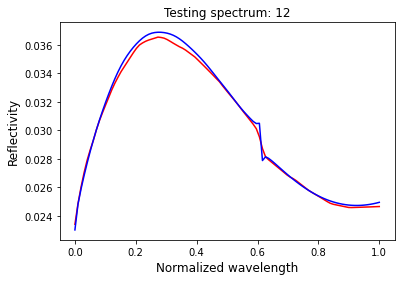

 MA Percentage error is: 0.6860939736832973.


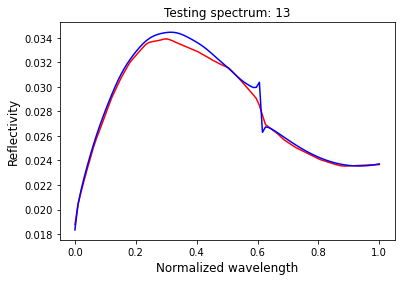

 MA Percentage error is: 1.0323997465774717.


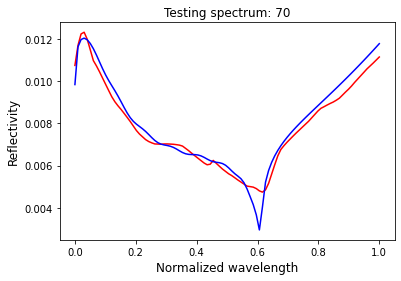

 MA Percentage error is: 5.128038582811798.


In [17]:
viz_forward_prediction(df3,model_forward, 12)
viz_forward_prediction(df3,model_forward, 13)
viz_forward_prediction(df3,model_forward ,70)

In [18]:
# Test forward model with test extra data 

def viz_test_extra_data(file_path,filename):
    #read the data with pandas and convert to a dataframe
    df_test_out = pd.read_csv(file_path+filename, sep = " ",skiprows=1,header = None,delimiter=r"\s+",names = ['h','top','base','wavelength','Reflectance'])
    #example: data/Test model data/extra_11.txt
    #convert to nanometers:
    df_test_out['h'] = df_test_out['h']* 10**9
    df_test_out['top'] = df_test_out['top']* 10**9
    df_test_out['base'] = df_test_out['base']* 10**9
    df_test_out['wavelength'] = df_test_out['wavelength']* 10**3

    df_test_out['base'] = df_test_out['base'] + df_test_out['top']
    # scale it
    df_test_out[['h','top','base','wavelength']] = scaler_f.transform(df_test_out[['h','top','base','wavelength']])

    pre_heldout= model_forward.predict(df_test_out.drop(['Reflectance'], axis=1))

    plt.plot(df_test_out['wavelength'], pre_heldout,'r') 
    plt.plot(df_test_out['wavelength'], df_test_out['Reflectance'], 'b')
    
    plt.title('Testing spectrum: '+ filename ,fontsize=12)
    plt.ylabel('Reflectivity',fontsize=12)
    plt.xlabel('Normalized wavelength',fontsize=12)
    error_percentage = sklearn.metrics.mean_absolute_percentage_error(df_test_out['Reflectance'], pre_heldout)
    
    
    
    plt.show()
    #show error
    print( f" MA Percentage error is: {100*error_percentage}.")


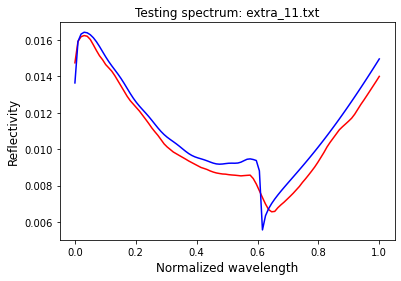

 MA Percentage error is: 6.082376045141666.


In [19]:
viz_test_extra_data('data/Test model data/','extra_11.txt')

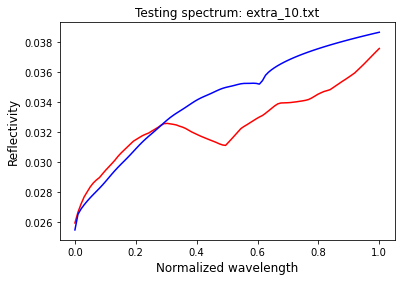

 MA Percentage error is: 5.363378020058667.


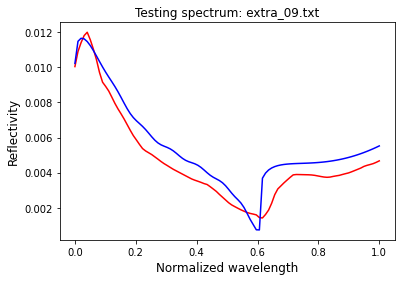

 MA Percentage error is: 19.892075642626647.


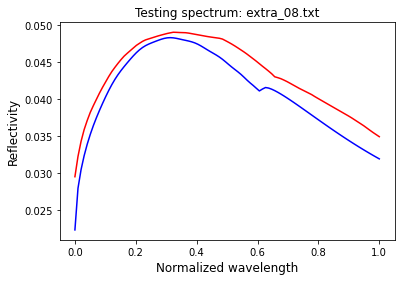

 MA Percentage error is: 6.149605913302843.


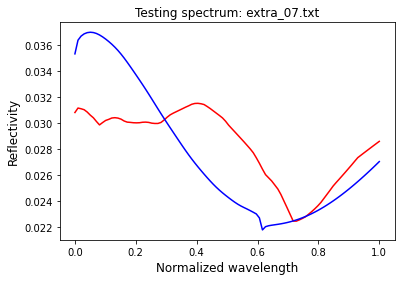

 MA Percentage error is: 11.526366471534008.


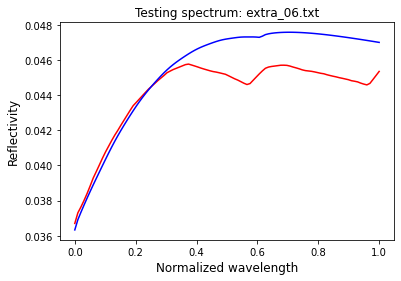

 MA Percentage error is: 2.957941615064821.


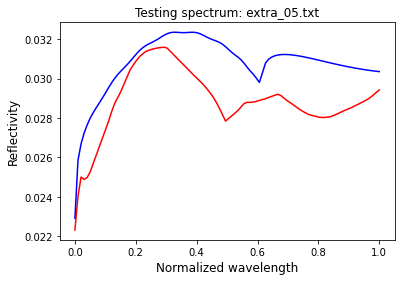

 MA Percentage error is: 6.167441075176096.


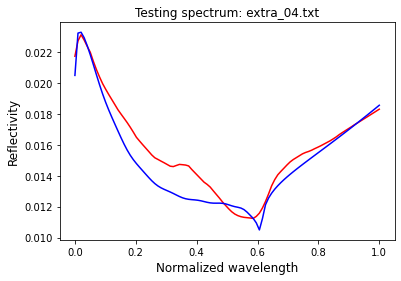

 MA Percentage error is: 5.8968720831297885.


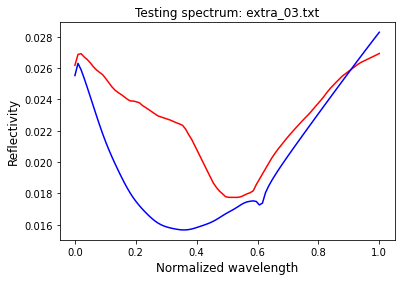

 MA Percentage error is: 15.426784934908955.


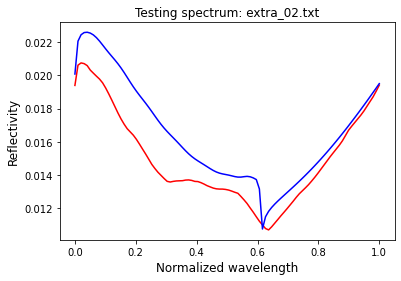

 MA Percentage error is: 8.915511065080413.


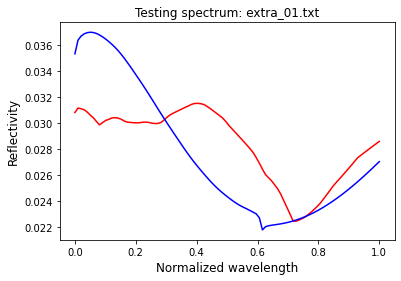

 MA Percentage error is: 11.526366471532215.


In [20]:
viz_test_extra_data('data/Test model data/','extra_10.txt')
viz_test_extra_data('data/Test model data/','extra_09.txt')
viz_test_extra_data('data/Test model data/','extra_08.txt')
viz_test_extra_data('data/Test model data/','extra_07.txt')
viz_test_extra_data('data/Test model data/','extra_06.txt')
viz_test_extra_data('data/Test model data/','extra_05.txt')
viz_test_extra_data('data/Test model data/','extra_04.txt')
viz_test_extra_data('data/Test model data/','extra_03.txt')
viz_test_extra_data('data/Test model data/','extra_02.txt')
viz_test_extra_data('data/Test model data/','extra_01.txt')

### Transfer learning part

##### work flow (taken from: https://keras.io/guides/transfer_learning/)

The typical transfer learning workflow that can be implemented in Keras:

1) Instantiate a base model and load pre-trained weights into it.
2) Freeze all layers in the base model by setting trainable = False.
3) Create a new model on top of the output of one (or several) layers from the base model.
4) Train your new model on your new dataset.

## 0) Initiate model and training set

#Ιn our case we have to make a new model and training set

#We are going to use data that it has limited X feature space and through trasnfer learning we are going to expand that.

We are going to create new fucntions to that workflow

In [21]:
# 0.1) Combine extra data with actual data
# 0.2) Split data for transfer learning and normal learning
# 0.3) 

### 0.1) Combine extra data with actual data

In [22]:
def combine_extra_data(file_path,filename,df3):
    #read the data with pandas and convert to a dataframe
    df_test_out = pd.read_csv(file_path+filename, sep = " ",skiprows=1,header = None,delimiter=r"\s+",names = ['h','top','base','wavelength','Reflectance'])
    #example: data/Test model data/extra_11.txt
    #convert to nanometers:
    df_test_out['h'] = df_test_out['h']* 10**9
    df_test_out['top'] = df_test_out['top']* 10**9
    df_test_out['base'] = df_test_out['base']* 10**9
    df_test_out['wavelength'] = df_test_out['wavelength']* 10**3

    df_test_out['base'] = df_test_out['base'] + df_test_out['top']
    
    sim_index_max = df3['Simulation index'].max()
    
    df_test_out['Simulation index'] = sim_index_max+1
    
    return pd.concat([df3,df_test_out])

In [23]:
#WATCH OUT: do not runc two times

#read the data with pandas and convert to a dataframe
df2 = pd.read_csv("data/grating_nanomet_v1.txt", sep = " ",skiprows=1,header = None,delimiter=r"\s+",names = ['h','top','base','wavelength','Reflectance'])

#Add index simulation based on unique input values
df3 = add_simulation_index(df2)


for i in range(1,10):
    df3 = combine_extra_data('data/Test model data/','extra_0'+str(i)+'.txt',df3)
    
    
    
df3 = combine_extra_data('data/Test model data/','extra_10.txt',df3)




In [24]:
df3.describe()

,Simulation index,h,top,base,wavelength,Reflectance
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000
mean,55.500000,141.309091,29.863636,54.745455,550.000000,0.025655
std,31.754396,44.165288,14.092855,22.508572,87.476916,0.011618
min,1.000000,80.000000,10.000000,10.000000,400.000000,0.000734
25%,28.000000,115.000000,20.000000,40.000000,475.000000,0.017338
50%,55.500000,155.500000,30.000000,53.750000,550.000000,0.025172
75%,83.000000,182.000000,40.000000,70.000000,625.000000,0.033131
max,110.000000,210.000000,55.000000,105.000000,700.000000,0.055296


#### 0.2) Split data for transfer learning and normal learning

In [25]:
df_transf1 = df3[(df3['h'] < 100)]
#df_transf2 =  df3[(df3['h'] > 180)]
#df_transf = pd.concat([df_transf1,df_transf2])
df_transf = df_transf1.copy()
len(df_transf)

2500

In [26]:
df_transf.describe()

,Simulation index,h,top,base,wavelength,Reflectance
count,2500.000000,2500.0,2500.000000,2500.000000,2500.000000,2500.000000
mean,13.000000,80.0,30.000000,55.000000,550.000000,0.029164
std,7.212545,0.0,14.144965,22.642992,87.490439,0.008324
min,1.000000,80.0,10.000000,10.000000,400.000000,0.001993
25%,7.000000,80.0,20.000000,40.000000,475.000000,0.023345
50%,13.000000,80.0,30.000000,55.000000,550.000000,0.028033
75%,19.000000,80.0,40.000000,70.000000,625.000000,0.034101
max,25.000000,80.0,50.000000,100.000000,700.000000,0.053516


In [27]:
#df_normal = df3[(df3['h'] > 100) & (df3['h'] < 180)]
df_normal = df3[(df3['h'] > 100)]
len(df_normal)

8500

In [28]:
df_normal.describe()

,Simulation index,h,top,base,wavelength,Reflectance
count,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000
mean,68.000000,159.341176,29.823529,54.670588,550.000000,0.024623
std,24.537132,33.067852,14.078074,22.469672,87.478085,0.012232
min,26.000000,105.000000,10.000000,10.000000,400.000000,0.000734
25%,47.000000,120.000000,20.000000,40.000000,475.000000,0.015087
50%,68.000000,160.000000,30.000000,52.500000,550.000000,0.023540
75%,89.000000,200.000000,40.000000,70.000000,625.000000,0.032740
max,110.000000,210.000000,55.000000,105.000000,700.000000,0.055296


#### 0.3) Scale

In [29]:
#getting our features
features = df_normal.drop(['Simulation index', 'Reflectance'],axis= 1).columns.tolist()

#scale input
scaler_f = MinMaxScaler()

#IMPORTANT STEP: WE SCALE THE INPUTS BASE ON THE WHOLE DATA
scaler_f.fit_transform(df3[['h','top','base','wavelength']])

df_normal[['h','top','base','wavelength']] = scaler_f.transform(df_normal[['h','top','base','wavelength']])

<ipython-input-29-f3ca78bf183e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normal[['h','top','base','wavelength']] = scaler_f.transform(df_normal[['h','top','base','wavelength']])
C:\Users\AX-St\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [30]:
df_normal

,Simulation index,h,top,base,wavelength,Reflectance
2500,26,0.307692,0.000000,0.000000,0.000000,0.050818
2501,26,0.307692,0.000000,0.000000,0.010101,0.050368
2502,26,0.307692,0.000000,0.000000,0.020202,0.049811
2503,26,0.307692,0.000000,0.000000,0.030303,0.049221
2504,26,0.307692,0.000000,0.000000,0.040404,0.048606
...,...,...,...,...,...,...
95,110,0.784615,0.155556,0.315789,0.959596,0.038479
96,110,0.784615,0.155556,0.315789,0.969697,0.038529
97,110,0.784615,0.155556,0.315789,0.979798,0.038578
98,110,0.784615,0.155556,0.315789,0.989899,0.038626


#### 0.4) Train & Test

In [31]:
#DROP OUT spectra for testing later
df_normal_4 = df_normal[(df_normal['Simulation index'] != 13) & (df_normal['Simulation index'] != 14) & (df_normal['Simulation index'] != 15) & (df_normal['Simulation index'] != 70) & (df_normal['Simulation index'] != 71)]
df_normal_5 = df_normal[(df_normal['Simulation index'] == 13) | (df_normal['Simulation index'] == 14) | (df_normal['Simulation index'] == 15) | (df_normal['Simulation index'] == 70) | (df_normal['Simulation index'] == 71)]


52/52 [==============================] - 0s 990us/step - loss: 1.6526e-07 - mean_absolute_percentage_error: 1.8956


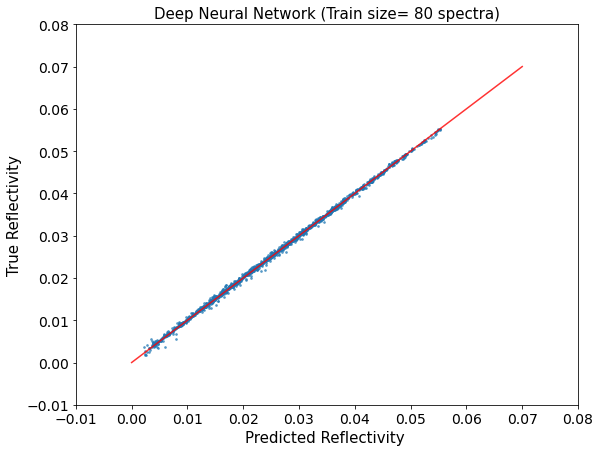

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    df_normal_4.drop(['Simulation index', 'Reflectance'], axis=1), # predictive variables
    df_normal_4['Reflectance'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=8790, # we are setting the seed here
)

X_train.shape, X_test.shape
# get the model
def get_model(n_inputs, n_outputs):
    
	net1Model=keras.models.Sequential()
	net1Model.add(Dense(n_inputs,input_shape=(4,)))
	net1Model.add(Dense(240))
	net1Model.add(Activation('relu'))
	net1Model.add(Dense(30))
	net1Model.add(Activation('relu'))
	net1Model.add(Dense(1024))
	net1Model.add(Activation('relu'))
	net1Model.add(Dense(n_outputs))
	net1Model.compile(optimizer='Adam',loss='mse',metrics= MeanAbsolutePercentageError())
	return net1Model

n_inputs, n_outputs = X_train.shape[1],1
model_forward = get_model(n_inputs, n_outputs)

# fit model
model_forward.fit(X_train, y_train, verbose=0, epochs=100)

# evaluate model on test set
#mae = model.evaluate(X_train, y_train, verbose=0)
mae = model_forward.evaluate(X_test, y_test, verbose=1)    
pred= model_forward.predict(X_test)

plt.figure(figsize=(9,7))
plt.scatter(pred,y_test,alpha=0.6,s=3)
plt.plot([0, 0.07],[0, 0.07],'r',alpha=0.8)
plt.ylabel('True Reflectivity',fontsize=15)
plt.xlabel('Predicted Reflectivity ',fontsize=15)
plt.title('Deep Neural Network (Train size= 80 spectra)',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.01, 0.08])
plt.ylim([-0.01,  0.08])
plt.show()


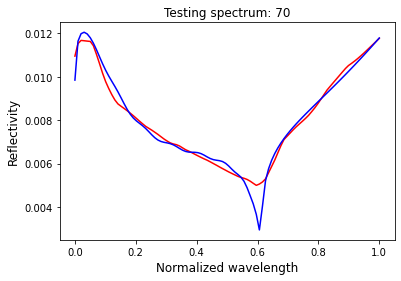

 MA Percentage error is: 4.0065281746798.


In [33]:
viz_forward_prediction(df_normal_5,model_forward, 70)

In [34]:
#Test 

In [35]:
df_transf

,Simulation index,h,top,base,wavelength,Reflectance
0,1,80.0,10.0,10.0,400.000000,0.044171
1,1,80.0,10.0,10.0,403.030303,0.045151
2,1,80.0,10.0,10.0,406.060606,0.046044
3,1,80.0,10.0,10.0,409.090909,0.046886
4,1,80.0,10.0,10.0,412.121212,0.047678
...,...,...,...,...,...,...
2495,25,80.0,50.0,100.0,687.878788,0.018288
2496,25,80.0,50.0,100.0,690.909091,0.018266
2497,25,80.0,50.0,100.0,693.939394,0.018250
2498,25,80.0,50.0,100.0,696.969697,0.018240


In [36]:
#getting our features
features = df_normal.drop(['Simulation index', 'Reflectance'],axis= 1).columns.tolist()

df_transf[['h','top','base','wavelength']] = scaler_f.transform(df_transf[['h','top','base','wavelength']])

79/79 [==============================] - 0s 771us/step - loss: 7.9676e-05 - mean_absolute_percentage_error: 28.2973


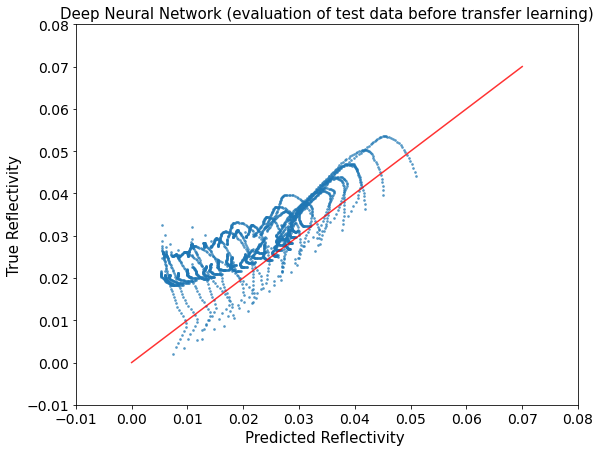

In [37]:
mae = model_forward.evaluate(df_transf[['h','top','base','wavelength']], df_transf['Reflectance'], verbose=1)    
pred= model_forward.predict(df_transf[['h','top','base','wavelength']])

plt.figure(figsize=(9,7))
plt.scatter(pred,df_transf['Reflectance'],alpha=0.6,s=3)
plt.plot([0, 0.07],[0, 0.07],'r',alpha=0.8)
plt.ylabel('True Reflectivity',fontsize=15)
plt.xlabel('Predicted Reflectivity ',fontsize=15)
plt.title('Deep Neural Network (evaluation of test data before transfer learning)',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.01, 0.08])
plt.ylim([-0.01,  0.08])
plt.show()

In [38]:
df_transf['Simulation index'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)

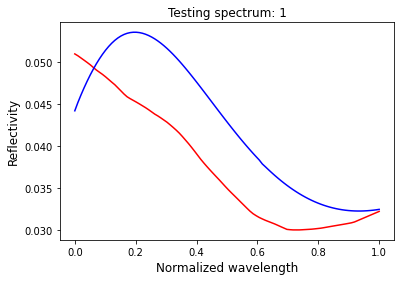

 MA Percentage error is: 12.483799914207594.


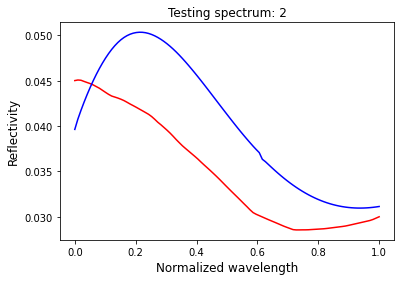

 MA Percentage error is: 13.71680202438915.


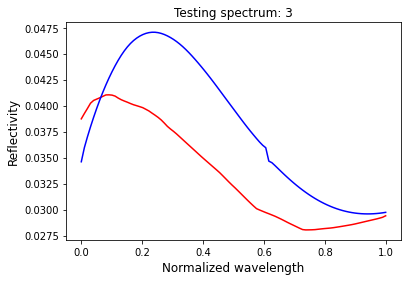

 MA Percentage error is: 12.159765674026161.


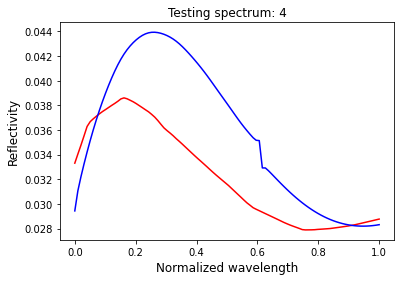

 MA Percentage error is: 10.10540688399746.


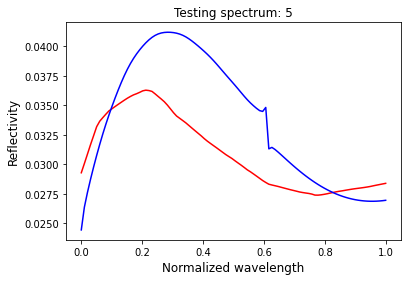

 MA Percentage error is: 9.98393941063903.


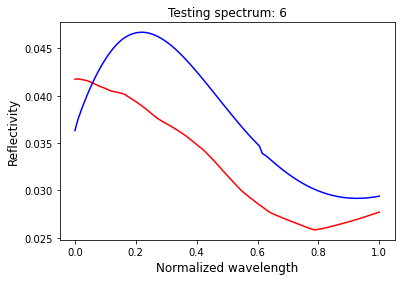

 MA Percentage error is: 13.853889370075512.


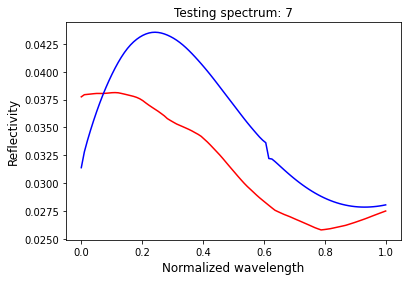

 MA Percentage error is: 11.58275735392667.


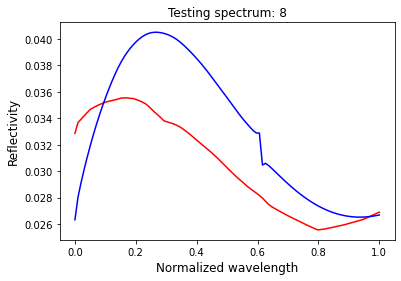

 MA Percentage error is: 9.857460316769668.


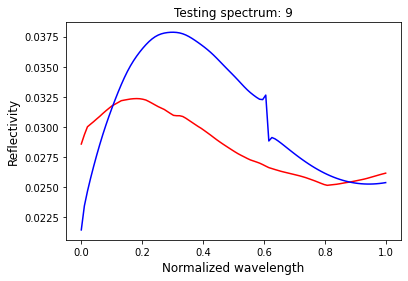

 MA Percentage error is: 10.676949712572977.


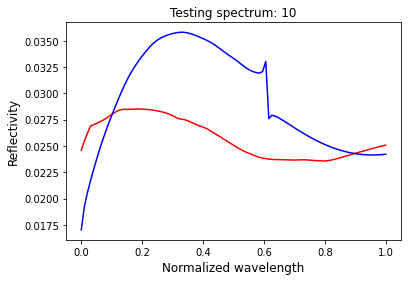

 MA Percentage error is: 14.613353056544181.


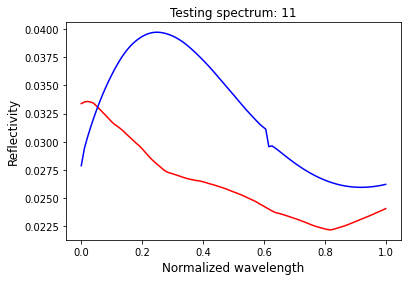

 MA Percentage error is: 19.648465893671663.


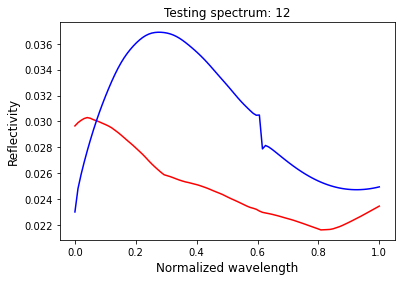

 MA Percentage error is: 18.81573959730681.


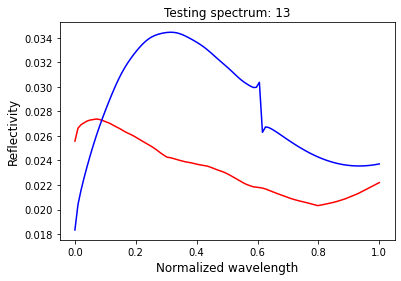

 MA Percentage error is: 19.852179798584352.


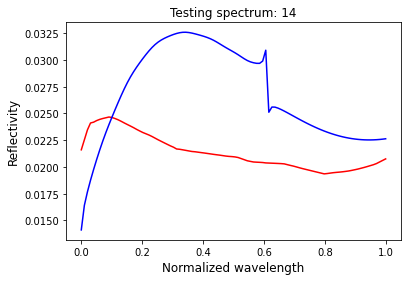

 MA Percentage error is: 22.42578940846602.


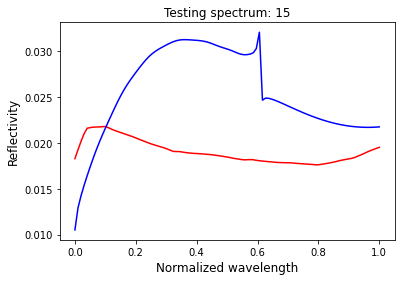

 MA Percentage error is: 27.745248527272455.


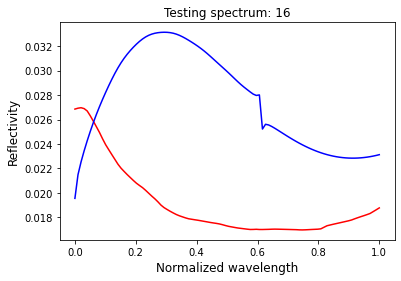

 MA Percentage error is: 31.44312009274358.


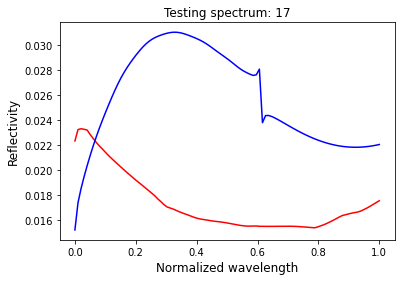

 MA Percentage error is: 33.69335726030049.


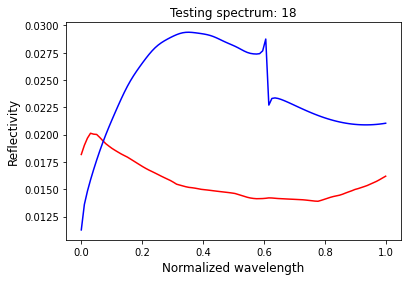

 MA Percentage error is: 36.52034121323856.


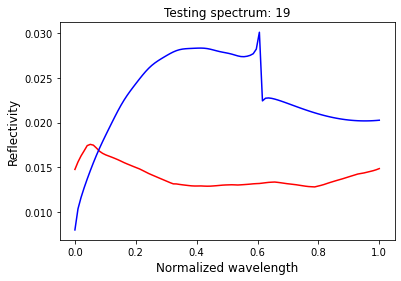

 MA Percentage error is: 40.54960804867406.


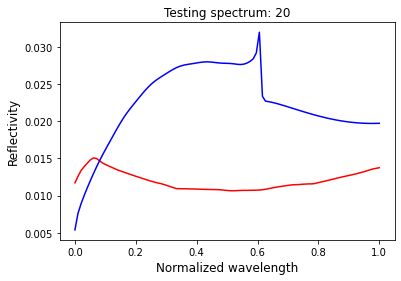

 MA Percentage error is: 46.96855786698222.


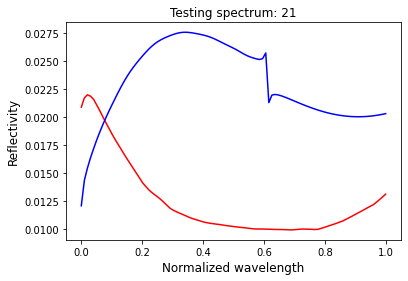

 MA Percentage error is: 48.052870667032586.


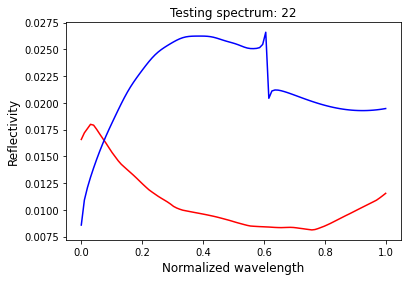

 MA Percentage error is: 52.5601343021509.


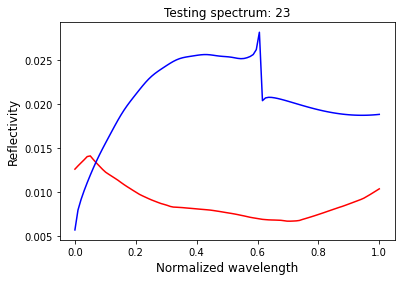

 MA Percentage error is: 57.95169307584958.


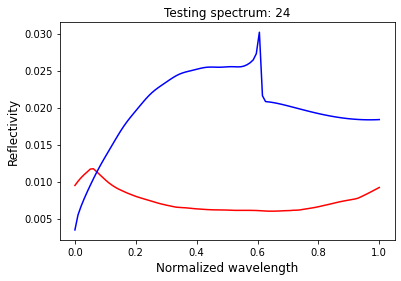

 MA Percentage error is: 63.70232111620992.


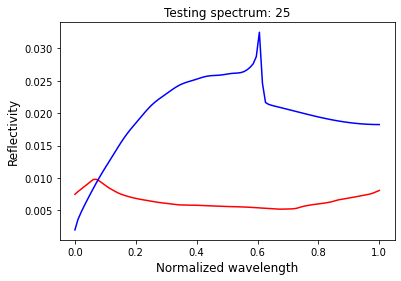

 MA Percentage error is: 68.46869603553577.


In [39]:
for i in df_transf['Simulation index'].unique():
    viz_forward_prediction(df_transf,model_forward, i)

### 0.5) Transfer learning

In [40]:
model_forward.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 240)               1200      
_________________________________________________________________
activation_3 (Activation)    (None, 240)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                7230      
_________________________________________________________________
activation_4 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              31744     
_________________________________________________________________
activation_5 (Activation)    (None, 1024)             

In [41]:
model_forward.trainable = False
base_inputs = model_forward.layers[0].input
final_outputs  = model_forward.layers[-4].output

model_forward = keras.Model(inputs = base_inputs, outputs = final_outputs)
#model.add(Dense(1, activation='ReLU'))
print(model_forward.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5_input (InputLayer)   [(None, 4)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 240)               1200      
_________________________________________________________________
activation_3 (Activation)    (None, 240)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                7230      
_________________________________________________________________
activation_4 (Activation)    (None, 30)                0         
Total params: 8,450
Trainable params: 0
Non-trainable params: 8,450
____________________________________________________

In [42]:
model_forward.trainable = False

In [43]:
for layer in model_forward.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000139BA275460> False
<tensorflow.python.keras.layers.core.Dense object at 0x00000139B701B6D0> False
<tensorflow.python.keras.layers.core.Dense object at 0x00000139BA54B310> False
<tensorflow.python.keras.layers.core.Activation object at 0x00000139B79D2DC0> False
<tensorflow.python.keras.layers.core.Dense object at 0x00000139BA216910> False
<tensorflow.python.keras.layers.core.Activation object at 0x00000139BA88F6D0> False


In [44]:
# Create the model
model = Sequential()
# Add the base model
model.add(model_forward)
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1))



In [45]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 30)                8450      
_________________________________________________________________
activation_6 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              31744     
_________________________________________________________________
activation_7 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1025      
Total params: 41,219
Trainable params: 32,769
Non-trainable params: 8,450
_________________________________________________________________
None


In [46]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x00000139BAA74D00> False
<tensorflow.python.keras.layers.core.Activation object at 0x00000139B90D40A0> True
<tensorflow.python.keras.layers.core.Dense object at 0x00000139B8EAF2E0> True
<tensorflow.python.keras.layers.core.Activation object at 0x00000139B8EAFA60> True
<tensorflow.python.keras.layers.core.Dense object at 0x00000139BA66EBE0> True


Epoch 1/50
63/63 [==============================] - 0s 951us/step - loss: 8.8444e-05 - mean_absolute_percentage_error: 21.7643
Epoch 2/50
63/63 [==============================] - 0s 1ms/step - loss: 1.4039e-06 - mean_absolute_percentage_error: 3.5735
Epoch 3/50
63/63 [==============================] - 0s 1ms/step - loss: 8.3620e-07 - mean_absolute_percentage_error: 2.6373
Epoch 4/50
63/63 [==============================] - 0s 1ms/step - loss: 6.3676e-07 - mean_absolute_percentage_error: 2.2426
Epoch 5/50
63/63 [==============================] - 0s 2ms/step - loss: 5.4638e-07 - mean_absolute_percentage_error: 1.9922
Epoch 6/50
63/63 [==============================] - 0s 2ms/step - loss: 5.5272e-07 - mean_absolute_percentage_error: 2.0099: 0s - loss: 7.0142e-07 - mean_absolute_percentage_error: 2.
Epoch 7/50
63/63 [==============================] - 0s 2ms/step - loss: 4.8149e-07 - mean_absolute_percentage_error: 1.8380
Epoch 8/50
63/63 [==============================] - 0s 1ms/step - los

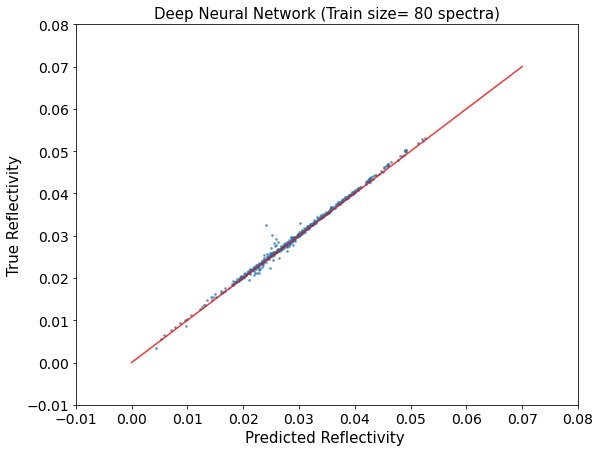

In [47]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_transf.drop(['Simulation index', 'Reflectance'], axis=1), # predictive variables
    df_transf['Reflectance'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=8790, # we are setting the seed here
)


n_inputs, n_outputs = X_train2.shape[1],1
model = get_model(n_inputs, n_outputs)

# fit model
model.fit(X_train2, y_train2, verbose=1, epochs=50)

# evaluate model on test set
#mae = model.evaluate(X_train, y_train, verbose=0)
mae = model.evaluate(X_test2, y_test2, verbose=1)    
pred= model.predict(X_test2)

plt.figure(figsize=(9,7))
plt.scatter(pred,y_test2,alpha=0.6,s=3)
plt.plot([0, 0.07],[0, 0.07],'r',alpha=0.8)
plt.ylabel('True Reflectivity',fontsize=15)
plt.xlabel('Predicted Reflectivity ',fontsize=15)
plt.title('Deep Neural Network (Train size= 80 spectra)',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.01, 0.08])
plt.ylim([-0.01,  0.08])
plt.show()


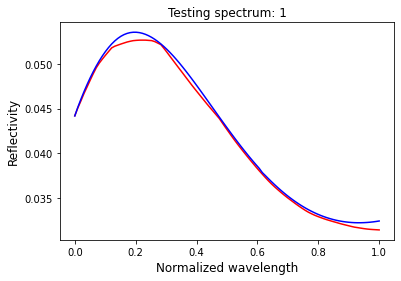

 MA Percentage error is: 0.9646001863717328.


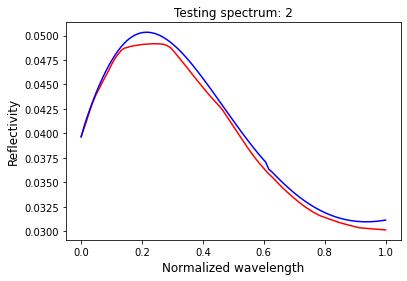

 MA Percentage error is: 1.635918141964216.


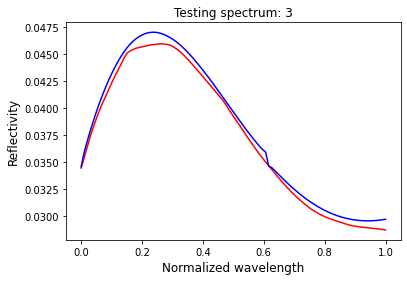

 MA Percentage error is: 1.6557377339440418.


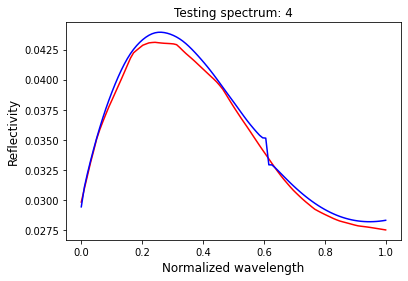

 MA Percentage error is: 1.3885110680674224.


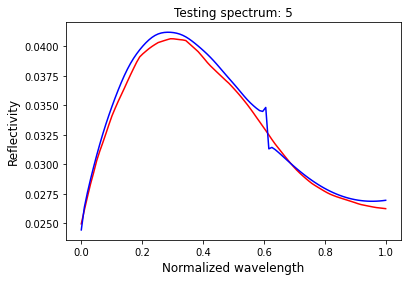

 MA Percentage error is: 1.5158961357023175.


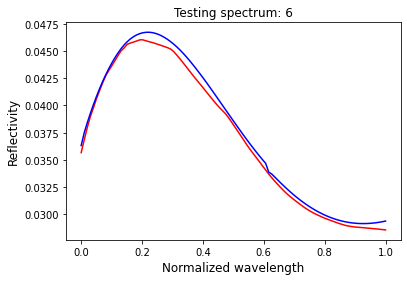

 MA Percentage error is: 1.3342955051649286.


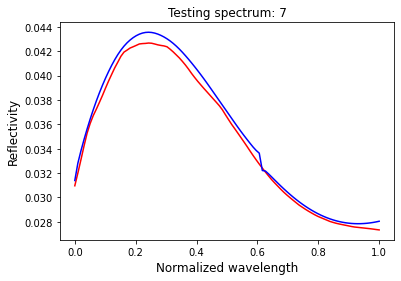

 MA Percentage error is: 1.4189609267736278.


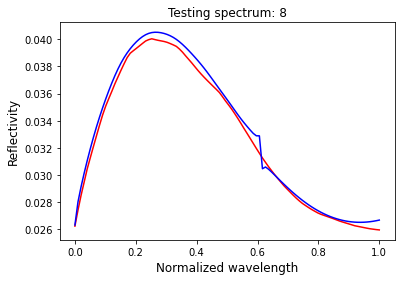

 MA Percentage error is: 1.2331824524808257.


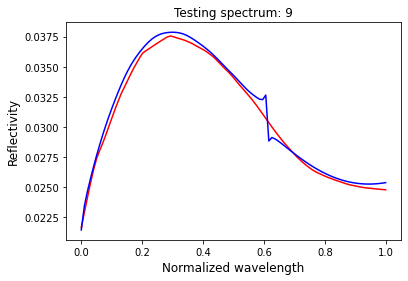

 MA Percentage error is: 1.3779086064452368.


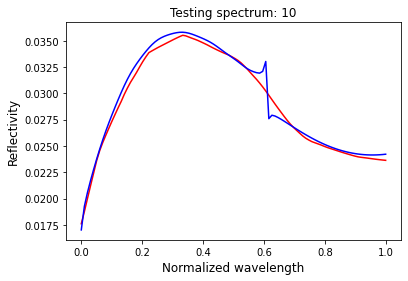

 MA Percentage error is: 1.6053869003052126.


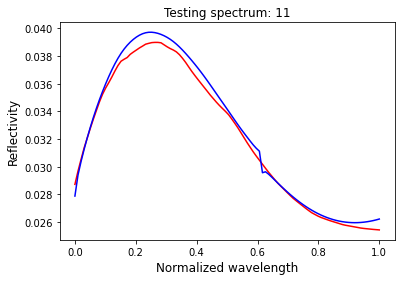

 MA Percentage error is: 1.2618292170556495.


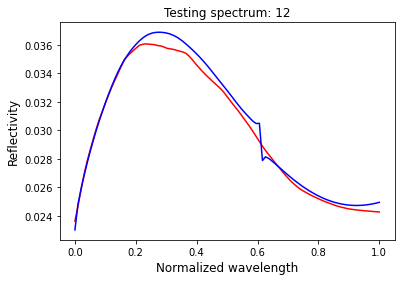

 MA Percentage error is: 1.3426965761184986.


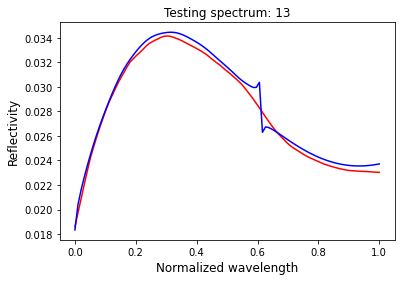

 MA Percentage error is: 1.531910898141619.


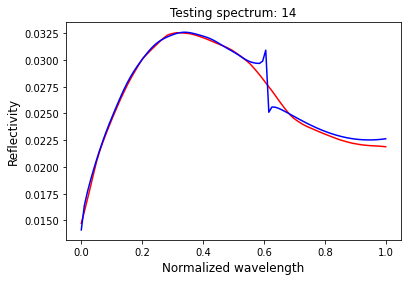

 MA Percentage error is: 1.3952497389874232.


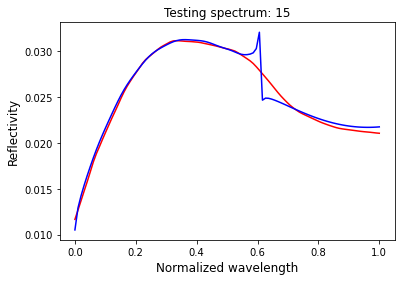

 MA Percentage error is: 1.8956202447165436.


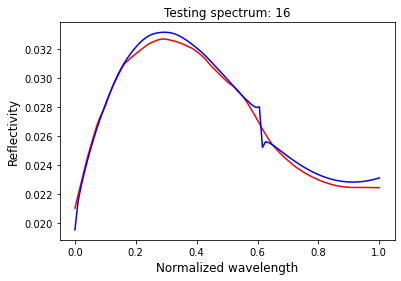

 MA Percentage error is: 1.2933732490672467.


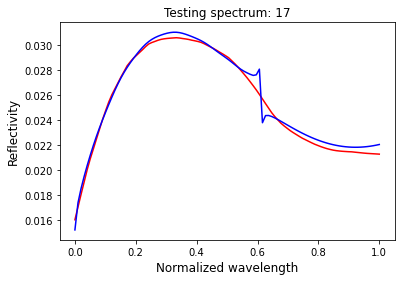

 MA Percentage error is: 1.4582229201236905.


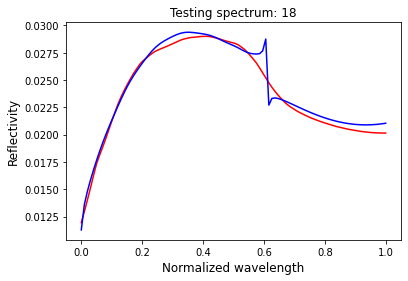

 MA Percentage error is: 2.083207096188733.


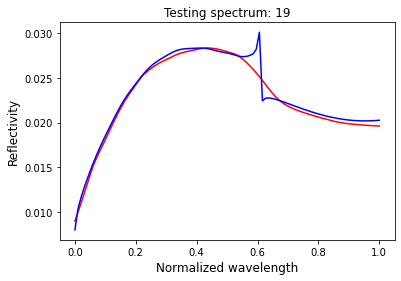

 MA Percentage error is: 2.1578187182264674.


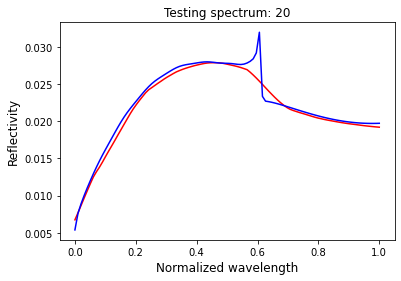

 MA Percentage error is: 2.8068239408486026.


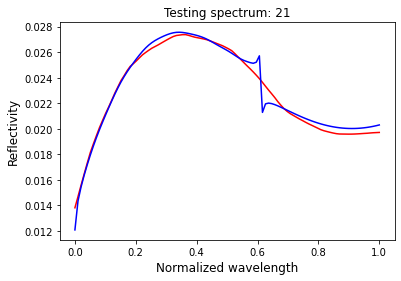

 MA Percentage error is: 1.6346812991207498.


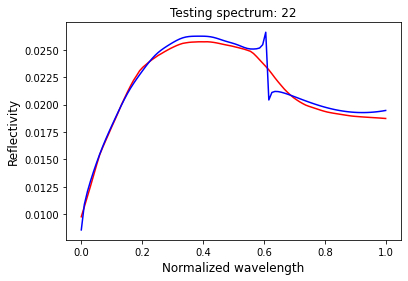

 MA Percentage error is: 2.135492614586664.


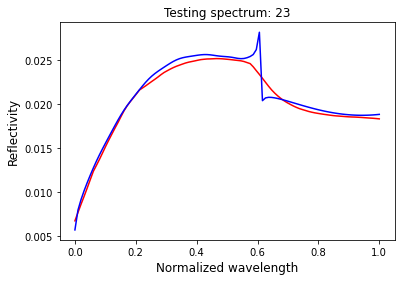

 MA Percentage error is: 2.6557163626221736.


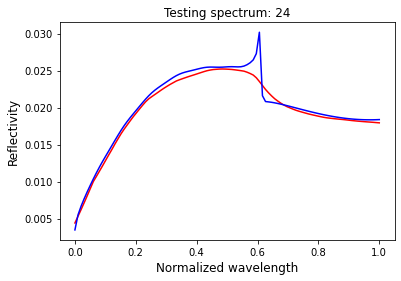

 MA Percentage error is: 3.079774233737095.


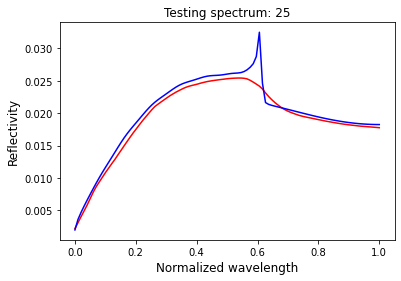

 MA Percentage error is: 4.3947997215272.


In [48]:
for i in df_transf['Simulation index'].unique():
    viz_forward_prediction(df_transf,model, i)

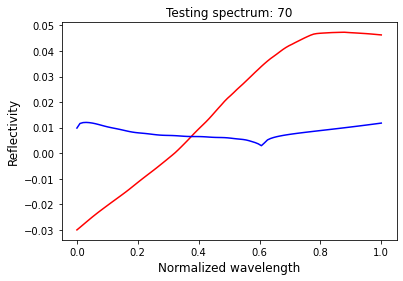

 MA Percentage error is: 323.2545959527075.


In [49]:
viz_forward_prediction(df_normal_5,model, 70)

In [50]:
for i in df_transf['Simulation index'].unique():

,Simulation index,h,top,base,wavelength,Reflectance
6900,70,0.615385,0.666667,0.842105,0.000000,0.009842
6901,70,0.615385,0.666667,0.842105,0.010101,0.011633
6902,70,0.615385,0.666667,0.842105,0.020202,0.011979
6903,70,0.615385,0.666667,0.842105,0.030303,0.012046
6904,70,0.615385,0.666667,0.842105,0.040404,0.011967
...,...,...,...,...,...,...
7095,71,0.615385,0.888889,0.421053,0.959596,0.022192
7096,71,0.615385,0.888889,0.421053,0.969697,0.022249
7097,71,0.615385,0.888889,0.421053,0.979798,0.022308
7098,71,0.615385,0.888889,0.421053,0.989899,0.022368


#### Lets predict with the transformed model the previous data

In [54]:
df_normal_4

,Simulation index,h,top,base,wavelength,Reflectance
2500,26,0.307692,0.000000,0.000000,0.000000,0.050818
2501,26,0.307692,0.000000,0.000000,0.010101,0.050368
2502,26,0.307692,0.000000,0.000000,0.020202,0.049811
2503,26,0.307692,0.000000,0.000000,0.030303,0.049221
2504,26,0.307692,0.000000,0.000000,0.040404,0.048606
...,...,...,...,...,...,...
95,110,0.784615,0.155556,0.315789,0.959596,0.038479
96,110,0.784615,0.155556,0.315789,0.969697,0.038529
97,110,0.784615,0.155556,0.315789,0.979798,0.038578
98,110,0.784615,0.155556,0.315789,0.989899,0.038626


260/260 [==============================] - 0s 588us/step - loss: 8.3603e-04 - mean_absolute_percentage_error: 139.4465


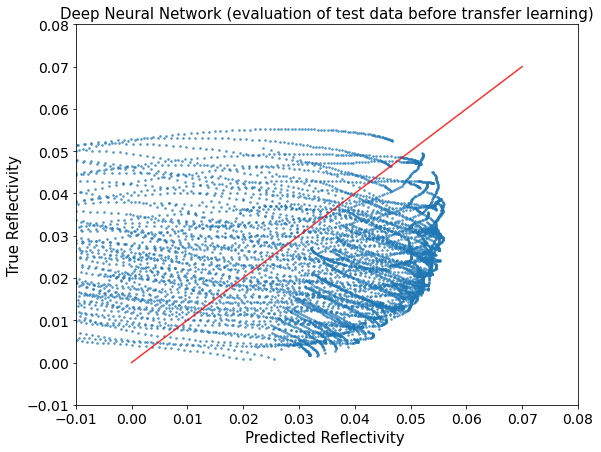

In [55]:
mae = model.evaluate(df_normal_4[['h','top','base','wavelength']],df_normal_4['Reflectance'], verbose=1)    
pred= model.predict(df_normal_4[['h','top','base','wavelength']])

plt.figure(figsize=(9,7))
plt.scatter(pred,df_normal_4['Reflectance'],alpha=0.6,s=3)
plt.plot([0, 0.07],[0, 0.07],'r',alpha=0.8)
plt.ylabel('True Reflectivity',fontsize=15)
plt.xlabel('Predicted Reflectivity ',fontsize=15)
plt.title('Deep Neural Network (evaluation of test data before transfer learning)',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#set_xlim(left, right)
plt.xlim([-0.01, 0.08])
plt.ylim([-0.01,  0.08])
plt.show()

In [56]:
# we observe really bad predictions. That means the transformed model can not predict the previous. Which means we have to use a different model in each case.